<a href="https://colab.research.google.com/github/kikiru328/Bone_Detection/blob/main/%EC%A2%85%EA%B5%AC/1%EA%B8%B0_%EA%B3%A8%EC%97%B0%EB%A0%B9_%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 패키지

In [ ]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import * # 모든 관절을 학습하기 위해 순환 함
import keras


In [ ]:
tf.__version__

'2.4.1'

In [ ]:
%cd /content/drive/MyDrive/project2/2_Modeling/01_model_learning/

/content/drive/MyDrive/project2/2_Modeling/01_model_learning


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## DataFrame 전처리
- 여기서 이미지 사이즈 조절
- 여기서 model이름 설정
- path 조절
- train_test_split

In [ ]:
path_CARPAL = "../"
path_LMCP = "../"
path_MMCP = "../"
path_TMCP = "../"
path_LPIP = "../"
path_MPIP = "../"
path_IP = "../"

In [ ]:
df = pd.read_csv("../../BA_total.csv")

In [ ]:
df.head()

,Unnamed: 0,index,No.,Group,등록번호,생년월일,성별,진료의,검사 시 나이,신장,체중,BMI,처방일자,시행일자,BA 1,BA 2,file_name,wrist_roi,middle_roi,thumb_roi,little_roi,BA,boneage,BA_z,gender
0,0,1,1,1568,8110925,2013-08-19,2,1,2.953425,88.9,11.3,14.3,2016-08-01,2016-08-01,3.25,3.25,1_F.jpg,1_F_w.jpg,1_F_m_M.jpg,1_F_t.jpg,1_F_p.jpg,3.250,39.0,-1.591783,0
1,1,2,2,440,5988227,2008-10-27,2,2,2.994521,95.9,13.5,14.7,2011-10-25,2011-10-25,1.75,1.75,2_F.jpg,2_F_w.jpg,2_F_m_M.jpg,2_F_t.jpg,2_F_p.jpg,1.750,21.0,-1.966701,0
2,2,3,3,1724,8292016,2013-08-08,2,1,3.010959,88.2,13.0,16.8,2016-08-11,2016-08-11,2.75,2.00,3_F.jpg,3_F_w.jpg,3_F_m_M.jpg,3_F_t.jpg,3_F_p.jpg,2.375,28.5,-1.810485,0
3,4,5,5,1264,7743478,2010-07-18,2,1,3.284932,90.8,14.0,17.0,2013-10-29,2013-10-29,3.75,4.25,5_F.jpg,5_F_w.jpg,5_F_m_M.jpg,5_F_t.jpg,5_F_p.jpg,4.000,48.0,-1.404324,0
4,5,6,6,1040,7579599,2011-04-06,2,1,3.312329,91.5,12.2,14.6,2013-12-11,2014-07-28,2.50,1.50,6_F.jpg,6_F_w.jpg,6_F_m_M.jpg,6_F_t.jpg,6_F_p.jpg,2.000,24.0,-1.904214,0


## 함수모음
- generator : input과 oupt을 만들어주는 함수
- plot_it : 학습후 모델 그래프를 만들고 저장해주는 함수
- mae_in_month : 정규화된 값을 학습시키기 때문에 개월로 변경한 mae계산해주는 함수

In [ ]:
ba_mean = df.boneage.mean()
ba_std = df.boneage.std()

In [ ]:
def generator(df,model,n):
    
    gender = np.array(df.gender)
    age = np.array(df.BA_z)
    CARPAL_in = []
    LMCP_in = []
    MMCP_in = []
    TMCP_in = []
    LPIP_in = []
    MPIP_in = []
    IP_in = []
    gender_in = []
    age_in = []
    
    error_list = []
    for i in range(len(df)):
        
        CARPAL_roi = df.loc[i,'CARPAL_roi']
        LMCP_roi = df.loc[i,'LMCP_roi']
        MMCP_roi = df.loc[i,'MMCP_roi']
        TMCP_roi = df.loc[i,'TMCP_roi']
        LPIP_roi = df.loc[i, 'LPIP_roi']
        MPIP_roi = df.loc[i,'MPIP_roi']
        IP_roi = df.loc[i,'IP_roi']
    
        
        img_CARPAL = cv2.imread(path_CARPAL+'/'+CARPAL_roi)
        img_LMCP = cv2.imread(path_LMCP+'/'+LMCP_roi)
        img_MMCP = cv2.imread(path_MMCP+'/'+MMCP_roi)
        img_TMCP = cv2.imread(path_TMCP+'/'+TMCP_roi)
        img_LPIP = cv2.imread(path_LPIP+'/'+LPIP_roi)
        img_MPIP = cv2.imread(path_MPIP+'/'+MPIP_roi)
        img_IP = cv2.imread(path_IP+'/'+IP_roi)
        

        try:
            img_CARPAL = cv2.resize(img_CARPAL, (224,224),cv2.INTER_AREA)
            img_LMCP = cv2.resize(img_LMCP, (100,500),cv2.INTER_AREA)
            img_MMCP = cv2.resize(img_MMCP, (100,500),cv2.INTER_AREA)
            img_TMCP = cv2.resize(img_TMCP, (100,500),cv2.INTER_AREA)
            img_LPIP = cv2.resize(img_LPIP, (100,500),cv2.INTER_AREA)
            img_MPIP = cv2.resize(img_MPIP, (100,500),cv2.INTER_AREA)
            img_IP = cv2.resize(img_IP, (100,500),cv2.INTER_AREA)
            
        except:
            continue

        CARPAL_in.append(img_CARPAL)
        LMCP_in.append(img_LMCP)
        MMCP_in.append(img_MMCP)
        TMCP_in.append(img_TMCP)
        LPIP_in.append(img_LPIP)
        MPIP_in.append(img_MPIP)
        IP_in.append(img_IP)
        
        gender_in.append(gender[i])
        age_in.append(age[i])
           
    CARPAL_in = np.array(CARPAL_in)
    LMCP_in = np.array(LMCP_in)
    MMCP_in = np.array(MMCP_in)
    TMCP_in = np.array(TMCP_in)
    LPIP_in = np.array(LPIP_in)
    MPIP_in = np.array(MPIP_in)
    IP_in = np.array(IP_in)

    gender_in = np.array(gender_in)
    age_in = np.array(age_in)
        
    if n==1:
        return age_in
        
    if n==2:
        return [gender_in,CARPAL_in,LMCP_in,MMCP_in,TMCP_in, LPIP_in, MPIP_in, IP_in],age_in
        
    if n==3:
        return [CARPAL_in,LMCP_in,MMCP_in,TMCP_in, LPIP_in, MPIP_in, IP_in,gender_in],age_in    

In [ ]:
Tdef show(img):
    plt.figure(figsize=(15, 10))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap = "gray")
    plt.show()

In [ ]:
# process시각화 및 손실함수

def plot_it(history):
    '''function to plot training and validation error'''
    fig, ax = plt.subplots( figsize=(20,10))
    ax.plot(history.history['mae_in_months'])
    ax.plot(history.history['val_mae_in_months'])
    plt.title('Model Error')
    plt.ylabel('error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    ax.grid(color='black')
    plt.show()
    fig = plt.gcf()
    fig.savefig("../03_model_visualization/"+model_name+".jpg")
    plt.close(fig)

In [ ]:
from tensorflow.keras.metrics import mean_absolute_error

def mae_in_months(x_p, y_p):
    '''function to return mae in months'''
    return mean_absolute_error((ba_std*x_p + ba_mean), (ba_std*y_p + ba_mean)) 

## 모델 생성

In [ ]:
import sys
sys.path.insert(0,'../../03_Modeling/01_model_module')

In [ ]:
def mae_in_months(x_p, y_p):
    '''function to return mae in months'''
    return mean_absolute_error((ba_std*x_p + ba_mean), (ba_std*y_p + ba_mean))  

In [ ]:
def tjnet3():
  
    
    #원본이미지 모델 (mobilnet)
    #mob_model = tf.keras.applications.MobileNet(input_shape = (bimg_size, bimg_size, 3),
                                                   #include_top = False,
                                                                                  #weights = 'imagenet')
    #mob_model.trainable = True
    #model_2 = Sequential()
    #model_2.add(mob_model)
    #model_2.add(GlobalAveragePooling2D())
    #model_2.add(Dense(1024, activation = 'relu')) # 반으로줄임 

    # CARPALroi 모델 (tj-net)

    i_input = Input(shape = (224,224,3))

    #block 1
    conv1 = ReLU()(Conv2D(32,3)(i_input))
    conv2 = ReLU()(Conv2D(32,3)(conv1))
    conv3 = ReLU()(Conv2D(64,3,padding='same')(conv2))# 이전 레이어의 입력 shape와 같게 출력 shape 만듦
    x = Conv2D(64,1)(conv3) # conv1,2,3 들어있음
    x = BatchNormalization()(x) # 이전 레이어에서 분포가 이상하게 바뀔수 있으므로 이를 조정해주는 역할을 함

    se = GlobalAveragePooling2D()(x) # 평균값을 남기고 나머지는 버린다.
    se = Dense(4,activation="relu")(se) #출력
    se = Dense(64,activation="relu")(se)
    se = Reshape([1,1,64])(se) # se에서 출력값을 reshape
    x = Multiply()([conv3,se])# conv층과 se층을 곱함

    short = Conv2D(64,(1,1))(conv2)
    short = BatchNormalization()(short)

    x = ReLU()(add([x,short])) #x와 short를 더한것을 relu함수에 넣는다.

    pool1 = MaxPool2D(pool_size=(2,2))(x) # 가장 큰 값만 남기고 나머지는 버린다. 반복될시 일정수준의 이동 불변성을 얻을수 있다.
    #block 2
    conv4 = ReLU()(Conv2D(60,1)(pool1))
    conv5 = ReLU()(Conv2D(192,3)(conv4))
    pool2 = MaxPool2D(pool_size=(2,2))(conv5)
    #block 3
    conv6 = ReLU()(Conv2D(512,3)(pool2))
    pool3 = MaxPool2D(pool_size=(2,2))(conv6)
    #block 4
    conv7 = ReLU()(Conv2D(512,3,padding='same')(pool3)) # 반으로 줄임
    pool4 = MaxPool2D(pool_size=(2,2))(conv7)
    i_output = Flatten()(pool4) # 특징 자동추출

    i_model = Model(inputs = i_input, outputs = i_output)
    
    # LMCP roi 모델 (tj-net)

    i_input1 = Input(shape = (500,100,3))
    
    #block 1
    conv1 = ReLU()(Conv2D(32,3)(i_input1)) 
    conv2 = ReLU()(Conv2D(32,3)(conv1))
    conv3 = ReLU()(Conv2D(64,3,padding='same')(conv2))
    x = Conv2D(64,1)(conv3)
    x = BatchNormalization()(x)

    se = GlobalAveragePooling2D()(x) # 평균 값만 남기고 나머지는 버린다.
    se = Dense(4,activation="relu")(se)
    se = Dense(64,activation="relu")(se)
    se = Reshape([1,1,64])(se)
    x = Multiply()([conv3,se])

    short = Conv2D(64,(1,1))(conv2)
    short = BatchNormalization()(short)

    x = ReLU()(add([x,short]))

    pool1 = MaxPool2D(pool_size=(2,2))(x)
    #block 2
    conv4 = ReLU()(Conv2D(60,1)(pool1))
    conv5 = ReLU()(Conv2D(192,3)(conv4))
    pool2 = MaxPool2D(pool_size=(2,2))(conv5)
    #block 3
    conv6 = ReLU()(Conv2D(256,3)(pool2))
    pool3 = MaxPool2D(pool_size=(2,2))(conv6)
    #block 4
    conv7 = ReLU()(Conv2D(512,3,padding='same')(pool3)) # 반으로 줄임
    pool4 = MaxPool2D(pool_size=(2,2))(conv7)
    i_output1 = Flatten()(pool4) # 특징 자동 추출

    i_model1 = Model(inputs = i_input1, outputs = i_output1)

    # MMCP roi 모델 (tj-net)

    i_input1 = Input(shape = (500,100,3))
    
    #block 1
    conv1 = ReLU()(Conv2D(32,3)(i_input1)) 
    conv2 = ReLU()(Conv2D(32,3)(conv1))
    conv3 = ReLU()(Conv2D(64,3,padding='same')(conv2))
    x = Conv2D(64,1)(conv3)
    x = BatchNormalization()(x)

    se = GlobalAveragePooling2D()(x)
    se = Dense(4,activation="relu")(se)
    se = Dense(64,activation="relu")(se)
    se = Reshape([1,1,64])(se)
    x = Multiply()([conv3,se])

    short = Conv2D(64,(1,1))(conv2)
    short = BatchNormalization()(short)

    x = ReLU()(add([x,short]))

    pool1 = MaxPool2D(pool_size=(2,2))(x)
    #block 2
    conv4 = ReLU()(Conv2D(60,1)(pool1))
    conv5 = ReLU()(Conv2D(192,3)(conv4))
    pool2 = MaxPool2D(pool_size=(2,2))(conv5)
    #block 3
    conv6 = ReLU()(Conv2D(256,3)(pool2))
    pool3 = MaxPool2D(pool_size=(2,2))(conv6)
    #block 4
    conv7 = ReLU()(Conv2D(512,3,padding='same')(pool3)) # 반으로 줄임
    pool4 = MaxPool2D(pool_size=(2,2))(conv7)
    i_output1 = Flatten()(pool4)

    i_model2 = Model(inputs = i_input1, outputs = i_output1)

    # TMCP roi 모델 (tj-net)

    i_input1 = Input(shape = (500,100,3))
    
    #block 1
    conv1 = ReLU()(Conv2D(32,3)(i_input1)) 
    conv2 = ReLU()(Conv2D(32,3)(conv1))
    conv3 = ReLU()(Conv2D(64,3,padding='same')(conv2))
    x = Conv2D(64,1)(conv3)
    x = BatchNormalization()(x)

    se = GlobalAveragePooling2D()(x) # 
    se = Dense(4,activation="relu")(se)
    se = Dense(64,activation="relu")(se)
    se = Reshape([1,1,64])(se)
    x = Multiply()([conv3,se])

    short = Conv2D(64,(1,1))(conv2)
    short = BatchNormalization()(short)

    x = ReLU()(add([x,short]))

    pool1 = MaxPool2D(pool_size=(2,2))(x)
    #block 2
    conv4 = ReLU()(Conv2D(60,1)(pool1))
    conv5 = ReLU()(Conv2D(192,3)(conv4))
    pool2 = MaxPool2D(pool_size=(2,2))(conv5)
    #block 3
    conv6 = ReLU()(Conv2D(256,3)(pool2))
    pool3 = MaxPool2D(pool_size=(2,2))(conv6)
    #block 4
    conv7 = ReLU()(Conv2D(512,3,padding='same')(pool3)) # 반으로 줄임
    pool4 = MaxPool2D(pool_size=(2,2))(conv7)
    i_output1 = Flatten()(pool4)

    i_model3 = Model(inputs = i_input1, outputs = i_output1)

    # LPIP roi 모델 (tj-net)

    i_input1 = Input(shape = (500,100,3))
    
    #block 1
    conv1 = ReLU()(Conv2D(32,3)(i_input1)) 
    conv2 = ReLU()(Conv2D(32,3)(conv1))
    conv3 = ReLU()(Conv2D(64,3,padding='same')(conv2))
    x = Conv2D(64,1)(conv3)
    x = BatchNormalization()(x)

    se = GlobalAveragePooling2D()(x)
    se = Dense(4,activation="relu")(se)
    se = Dense(64,activation="relu")(se)
    se = Reshape([1,1,64])(se)
    x = Multiply()([conv3,se])

    short = Conv2D(64,(1,1))(conv2)
    short = BatchNormalization()(short)

    x = ReLU()(add([x,short]))

    pool1 = MaxPool2D(pool_size=(2,2))(x)
    #block 2
    conv4 = ReLU()(Conv2D(60,1)(pool1))
    conv5 = ReLU()(Conv2D(192,3)(conv4))
    pool2 = MaxPool2D(pool_size=(2,2))(conv5)
    #block 3
    conv6 = ReLU()(Conv2D(256,3)(pool2))
    pool3 = MaxPool2D(pool_size=(2,2))(conv6)
    #block 4
    conv7 = ReLU()(Conv2D(512,3,padding='same')(pool3)) # 반으로 줄임
    pool4 = MaxPool2D(pool_size=(2,2))(conv7)
    i_output1 = Flatten()(pool4)

    i_model4 = Model(inputs = i_input1, outputs = i_output1)

    
    # MPIP roi 모델 (tj-net)

    i_input2 = Input(shape = (500,100,3))
    
    #block 1
    conv1 = ReLU()(Conv2D(32,3)(i_input2))
    conv2 = ReLU()(Conv2D(32,3)(conv1))
    conv3 = ReLU()(Conv2D(64,3,padding='same')(conv2))
    x = Conv2D(64,1)(conv3)
    x = BatchNormalization()(x)

    se = GlobalAveragePooling2D()(x)
    se = Dense(4,activation="relu")(se)    
    se = Dense(64,activation="relu")(se)   
    se = Reshape([1,1,64])(se)
    x = Multiply()([conv3,se])

    short = Conv2D(64,(1,1))(conv2)
    short = BatchNormalization()(short)

    x = ReLU()(add([x,short]))

    pool1 = MaxPool2D(pool_size=(2,2))(x)
    #block 2
    conv4 = ReLU()(Conv2D(60,1)(pool1))
    conv5 = ReLU()(Conv2D(192,3)(conv4))
    pool2 = MaxPool2D(pool_size=(2,2))(conv5)
    #block 3
    conv6 = ReLU()(Conv2D(256,3)(pool2))
    pool3 = MaxPool2D(pool_size=(2,2))(conv6)
    #block 4
    conv7 = ReLU()(Conv2D(512,3,padding='same')(pool3)) #반으로 줄임
    pool4 = MaxPool2D(pool_size=(2,2))(conv7)
    i_output2 = Flatten()(pool4)

    i_model5 = Model(inputs = i_input2, outputs = i_output2)

    
    # IP roi 모델 (tj-net)

    i_input3 = Input(shape = (500,100,3))
    
    #block 1
    conv1 = ReLU()(Conv2D(32,3)(i_input3))
    conv2 = ReLU()(Conv2D(32,3)(conv1))
    conv3 = ReLU()(Conv2D(64,3,padding='same')(conv2))
    x = Conv2D(64,1)(conv3)
    x = BatchNormalization()(x)

    se = GlobalAveragePooling2D()(x)
    se = Dense(4,activation="relu")(se)
    se = Dense(64,activation="relu")(se)
    se = Reshape([1,1,64])(se)
    x = Multiply()([conv3,se])

    short = Conv2D(64,(1,1))(conv2)
    short = BatchNormalization()(short)

    x = ReLU()(add([x,short]))

    pool1 = MaxPool2D(pool_size=(2,2))(x)
    #block 2
    conv4 = ReLU()(Conv2D(60,1)(pool1))
    conv5 = ReLU()(Conv2D(192,3)(conv4))
    pool2 = MaxPool2D(pool_size=(2,2))(conv5)
    #block 3
    conv6 = ReLU()(Conv2D(256,3)(pool2))
    pool3 = MaxPool2D(pool_size=(2,2))(conv6)
    #block 4
    conv7 = ReLU()(Conv2D(512,3,padding='same')(pool3)) # 이부분을 1024에서 512 로변경 
    pool4 = MaxPool2D(pool_size=(2,2))(conv7)
    i_output3 = Flatten()(pool4)

    i_model6 = Model(inputs = i_input3, outputs = i_output3)

    # gender 모델
    g_model = gender()

    #concat및 마무리
    con1 = concatenate([i_model.output,i_model1.output,i_model2.output,i_model3.output,i_model4.output,i_model5.output,i_model6.output])
    dense1 = ReLU()(Dense(1024)(con1)) # dense1,2,3을 다 반으로 변경
    con2 = concatenate([dense1,g_model.output])
    dense2 = ReLU()(Dense(512)(con2))
    dense3 = ReLU()(Dense(256)(dense2))
    model_out = Dense(1,activation = "linear")(dense3)
    model = Model([i_model.input,i_model1.input,i_model2.input,i_model3.input,i_model4.output,i_model5.output,i_model6.output,g_model.input],model_out)
    return model


In [ ]:
def gender(act='relu'):
    g_input = Input(shape = (1,))
    g_output = Dense(64,activation = act)(g_input)
    
    g_model = Model(inputs = g_input,outputs = g_output)
    return g_model

In [ ]:
model_name = "tjnet"
model_weight = model_name +"_weight.h5"

model = tjnet3()
model.save("../02_model_result/"+model_name+".h5")

model.compile(loss ='mse', optimizer= 'nadam', metrics = [mae_in_months] )

In [ ]:
model.input

[<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 500, 100, 3) dtype=float32 (created by layer 'input_2')>,
 <KerasTensor: shape=(None, 500, 100, 3) dtype=float32 (created by layer 'input_3')>,
 <KerasTensor: shape=(None, 500, 100, 3) dtype=float32 (created by layer 'input_4')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_5')>]

In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 500, 100, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 500, 100, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 500, 100, 3) 0                                            
____________________________________________________________________________________________

## train_val_set 만들기

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size = 0.2, random_state = 0)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_X,train_y = generator(train_df,model,3)
val_X,val_y = generator(val_df,model,3)

In [ ]:
len(train_df), len(val_df)

(976, 245)

In [ ]:
len(train_y),len(val_y)

(968, 242)

In [ ]:
train_y

array([-1.0806633 ,  1.28138819, -1.51012721,  1.43476815, -0.40579145,
        0.42246037,  0.36110839,  0.08502445, -1.66350717, -0.00700353,
        1.52679613, -1.0806633 ,  1.03598024,  0.57584034, -0.28308747,
        0.2997564 , -0.37511545, -0.74322737, -0.65119939,  1.28138819,
        0.02367246, -0.65119939, -1.63283118,  1.71085209,  0.7598963 ,
       -0.68187539, -0.98863532, -1.14201529, -0.86593135, -1.78621115,
       -0.77390337, -1.17269128, -0.43646744,  0.60651633,  0.57584034,
       -0.52849542, -0.52849542,  0.63719233, -0.46714343, -1.20336727,
       -0.77390337,  0.79057229,  0.20772842, -1.78621115, -0.00700353,
       -0.80457936, -0.34443946,  0.33043239, -1.47945121,  0.97462825,
       -0.98863532, -0.86593135,  0.7598963 ,  1.18936021, -0.25241148,
       -1.14201529,  0.60651633, -1.11133929,  1.18936021,  0.85192428,
       -0.09903151,  0.14637643, -0.49781943, -0.77390337, -1.44877522,
        0.17705243,  1.28138819,  0.20772842,  0.72922031, -0.55

## 초반에 loss 심한거 뺄려고 한번만 먼저 돌리기

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9755506308265167230
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15703311680
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6408713884576573982
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [ ]:
# model.load_weights("temp/"+model_weight)

model.fit(train_X,train_y,validation_data = (val_X,val_y),epochs = 1,batch_size=4)

242/242 [==============================] - 65s 156ms/step - loss: 1372.2788 - mae_in_months: 307.2294 - val_loss: 0.2786 - val_mae_in_months: 20.0052


## 모델학습

Epoch 1/100
242/242 [==============================] - 37s 152ms/step - loss: 0.3010 - mae_in_months: 19.2876 - val_loss: 0.1807 - val_mae_in_months: 16.2209
Epoch 2/100
242/242 [==============================] - 37s 151ms/step - loss: 1.0687 - mae_in_months: 31.0704 - val_loss: 0.9407 - val_mae_in_months: 41.0522
Epoch 3/100
242/242 [==============================] - 37s 151ms/step - loss: 0.1667 - mae_in_months: 15.1247 - val_loss: 0.1102 - val_mae_in_months: 13.0161
Epoch 4/100
242/242 [==============================] - 37s 151ms/step - loss: 0.2211 - mae_in_months: 15.2391 - val_loss: 0.0979 - val_mae_in_months: 11.8682
Epoch 5/100
242/242 [==============================] - 37s 151ms/step - loss: 0.0597 - mae_in_months: 9.1243 - val_loss: 0.0874 - val_mae_in_months: 11.0986
Epoch 6/100
242/242 [==============================] - 37s 151ms/step - loss: 1.1343 - mae_in_months: 16.5966 - val_loss: 0.3630 - val_mae_in_months: 22.9522
Epoch 7/100
242/242 [==============================] 

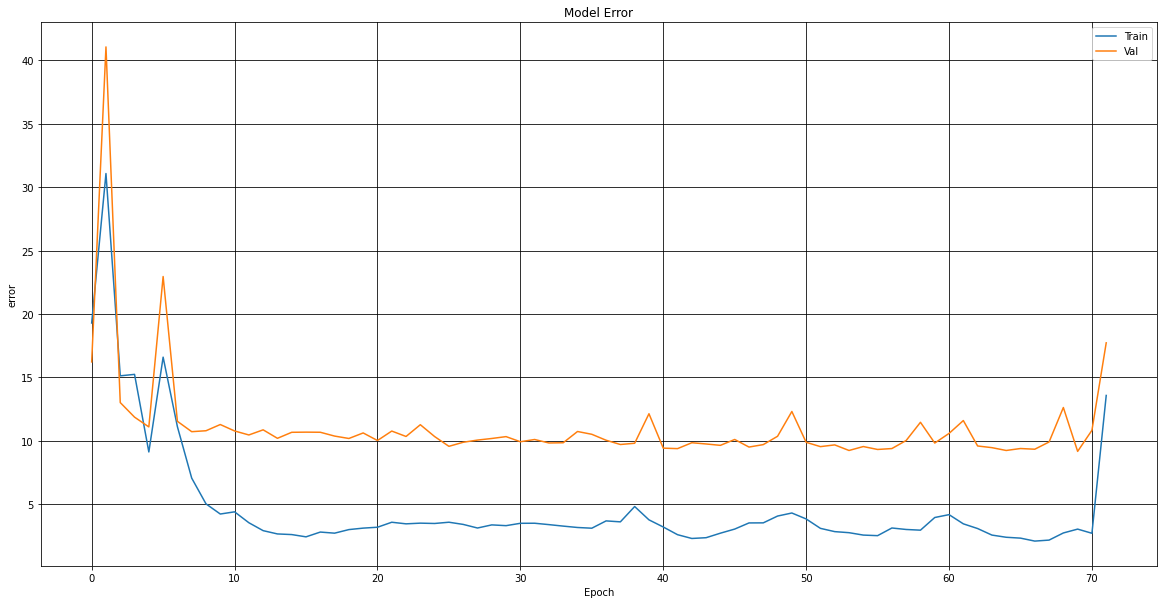

In [ ]:
# 모델 fit

epochs = 100                                                    
#early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience= 30,
                              verbose=0, mode='auto')

# mc = ModelCheckpoint("temp/"+model_weight, monitor='val_loss', mode='min', save_best_only=True)
rLR = ReduceLROnPlateau(
    monitor='val_loss',  # 검증 손실을 기준으로 callback이 호출됩니다
    factor=0.5,          # callback 호출시 학습률을 1/2로 줄입니다
    patience=30,         # epoch 10 동안 개선되지 않으면 callback이 호출됩니다
)

callbacks = [early_stopping,rLR]


#fit model
history = model.fit(train_X,train_y,
                    validation_data = (val_X,val_y),
                    epochs = epochs,
                    callbacks= callbacks,
                    batch_size=4)
plot_it(history)

## 평가 및 저장

In [ ]:
pred = model.predict(val_X)*ba_std+ba_mean
mse, mae = model.evaluate(val_X,val_y)

from sklearn.metrics import r2_score
# r2 = r2_score(val_df.boneage,pred)

print(f"mae_year : {mae/12}, rmse : {mse/12}" )

8/8 [==============================] - 1s 106ms/step - loss: 0.1957 - mae_in_months: 17.7258
mae_year : 1.4771540959676106, rmse : 0.016311207165320713


In [ ]:
from sklearn.metrics import mean_absolute_error
v = val_y*ba_std+ba_mean
mean_absolute_error(np.round(pred),v)/12,mean_absolute_error(pred,v)/12

(0.870412124756558, 0.8722866939793544)